# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные лежат в папке `/datasets/image_search/` или доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [4]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from collections import Counter
import os
import warnings
import re
import nltk
import math
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize

import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

from tensorflow.keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from keras.models import Sequential

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/anastasiamolcanova/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/anastasiamolcanova/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/anastasiamolcanova/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/anastasiamolcanova/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/anastasiamolcanova/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anastasiamolcanova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# pip install torch torchvision

In [6]:
# pip install keras

In [7]:
# pip install tensorflow

In [8]:
# директория 
path = 'to_upload'

In [9]:
# загрузка данных
df_train = pd.read_csv(os.path.join(path, 'train_dataset.csv'))
df_crowd = pd.read_csv(os.path.join(path, 'CrowdAnnotations.tsv'), sep='\t', header=None)
df_expert = pd.read_csv(os.path.join(path, 'ExpertAnnotations.tsv'), sep='\t', header=None)
df_test_query = pd.read_csv(os.path.join(path, 'test_queries.csv'), index_col=[0], sep='|')

In [10]:
train_images = []
for filename in os.listdir(os.path.join(path, 'train_images')):
    if filename.endswith('.jpg'):
        image_path = os.path.join(os.path.join(path, 'train_images'), filename)
        image = Image.open(image_path)
        train_images.append(image)

In [11]:
train_image = pd.DataFrame(train_images, columns=['image'])
train_image.name = 'train_image'

In [12]:
test_images = []
for filename in os.listdir(os.path.join(path, 'test_images')):
    if filename.endswith('.jpg'):
        image_path = os.path.join(os.path.join(path, 'test_images'), filename)
        image = Image.open(image_path)
        test_images.append(image)

In [13]:
test_image = pd.DataFrame(test_images, columns=['image'])
test_image.name = 'test_image'

In [14]:
# просмотр основной инфо о датасете
def greetings(name, df):
    """
    Просмотр основной инфо о датасете
    """
    print(name)
    display(df.head())
    df.info()
    print(df.isna().mean())
    print('')
    print('')

In [61]:
# оценим данные
greetings('train_dataset', df_train)
greetings('crowd_annotations', df_crowd)
greetings('expert_annotations', df_expert)
greetings('test_queries', df_test_query)

train_dataset


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text     score  \
0  A young child is wearing blue goggles and sitt...  0.000000   
1  A young child is wearing blue goggles and sitt...  0.000000   
2  A young child is wearing blue goggles and sitt...  0.333333   
3  A young child is wearing blue goggles and sitt...  1.000000   
4  A young child is wearing blue goggles and sitt...  0.000000   

                                      lem_query_text  
0  a young child is wearing blue goggles and sitt...  
1  a young child is wearing blue goggles and sitt...  
2  a young child is wearing blue goggles and sitt...  
3  a young child is wearing blue goggles and sitt...  
4  a young child is wearing blue goggles and sitt...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5712 entries, 0 to 5711
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image           5712 non-null   object 
 1   query_id        5712 non-null   object 
 2   query_text      5712 non-null   object 
 3   score           5712 non-null   float64
 4   lem_query_text  5712 non-null   object 
dtypes: float64(1), object(4)
memory usage: 223.3+ KB
image             0.0
query_id          0.0
query_text        0.0
score             0.0
lem_query_text    0.0
dtype: float64


crowd_annotations


0                            1    2  3  4
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2  1.0  3  0
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2  0.0  0  3
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2  0.0  0  3
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2  0.0  0  3
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2  0.0  0  3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       47830 non-null  object 
 1   1       47830 non-null  object 
 2   2       47830 non-null  float64
 3   3       47830 non-null  int64  
 4   4       47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
dtype: float64


expert_annotations


0                            1  2  3  4         5
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2  1  1  1  0.000000
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2  1  1  2  0.000000
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2  1  1  2  0.000000
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2  1  2  2  0.333333
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2  1  1  2  0.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       5822 non-null   object 
 1   1       5822 non-null   object 
 2   2       5822 non-null   int64  
 3   3       5822 non-null   int64  
 4   4       5822 non-null   int64  
 5   5       5696 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 273.0+ KB
0    0.000000
1    0.000000
2    0.000000
3    0.000000
4    0.000000
5    0.021642
dtype: float64


test_queries


query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  \
0  1177994172_10d143cb8d.jpg   
1  1177994172_10d143cb8d.jpg   
2  1177994172_10d143cb8d.jpg   
3  1177994172_10d143cb8d.jpg   
4  1177994172_10d143cb8d.jpg   

                                      lem_query_text  
0  two blonde boy one in a camouflage shirt and t...  
1      two boy are squirting water gun at each other  
2             two boy spraying each other with water  
3  two child wearing jean squirt water at each other  
4    two young boy are squirting water at each other

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   query_id        500 non-null    object
 1   query_text      500 non-null    object
 2   image           500 non-null    object
 3   lem_query_text  500 non-null    object
dtypes: object(4)
memory usage: 19.5+ KB
query_id          0.0
query_text        0.0
image             0.0
lem_query_text    0.0
dtype: float64




In [ ]:
# оценим количество уникальных значений
print(f"Количество уникальных изображений в обучающей выборке: {df_train['image'].nunique()}")
print(f"Количество уникальных изображений в тестовой выборке: {df_test_query['image'].nunique()}")
print(f"Количество уникальных запросов в обучающем выборке: {df_train['query_text'].nunique()}")
print(f"Количество экспертных оценок: {len(df_expert)}")
print(f"Количество оценок в краудсорсинговой выборке: {len(df_crowd)}")

In [72]:
# вывод изображений и их описания
def show_image_with_description(image_path, description):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(description)
    plt.axis('off')
    plt.show()

Описание: A young child is wearing blue goggles and sitting in a float in a pool .


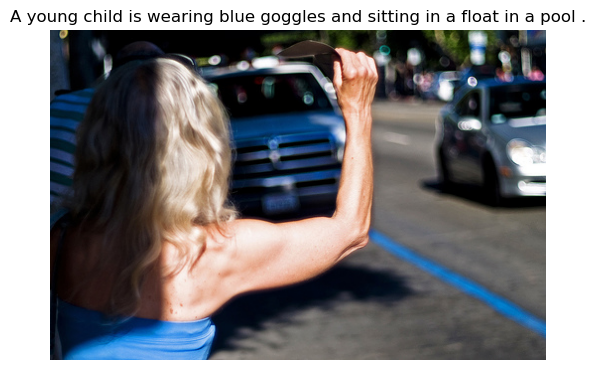

Описание: A young child is wearing blue goggles and sitting in a float in a pool .


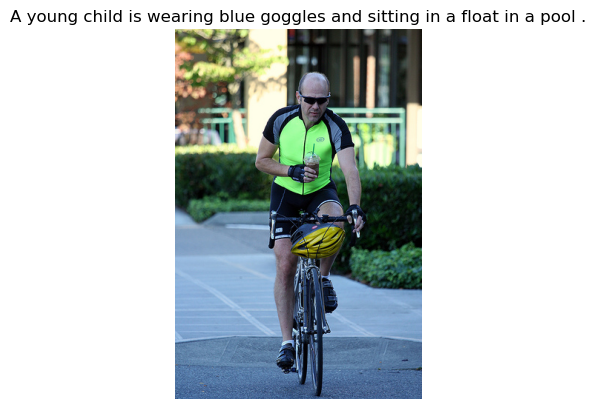

Описание: A young child is wearing blue goggles and sitting in a float in a pool .


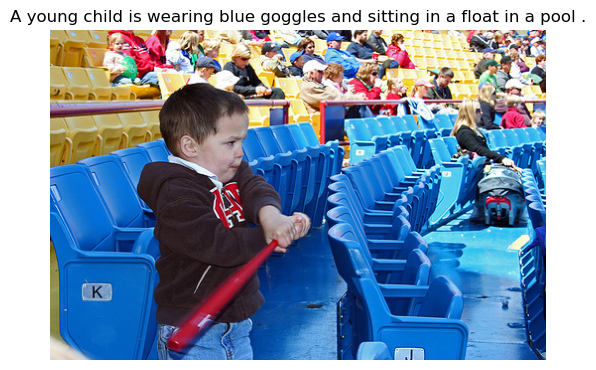

Описание: A young child is wearing blue goggles and sitting in a float in a pool .


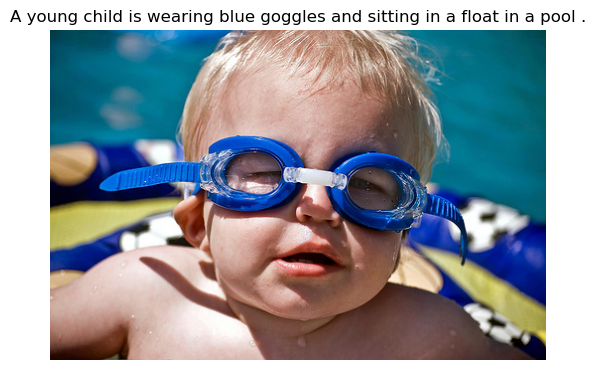

Описание: A young child is wearing blue goggles and sitting in a float in a pool .


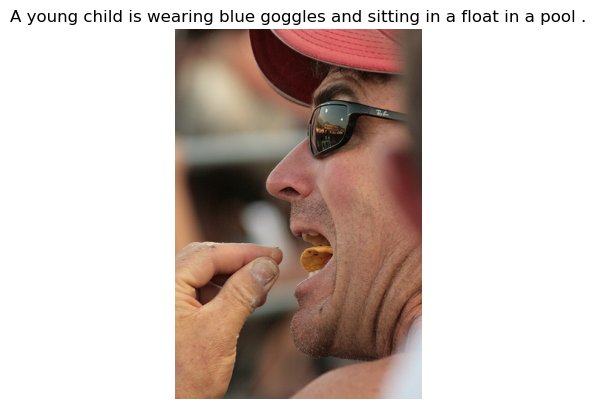

In [73]:
# путь к папке с изображениями
train_images_path = os.path.join(path, 'train_images')

# визуализация 5 изображений 
for idx in range(5):
    image_name = df_train.iloc[idx]['image']
    description = df_train.iloc[idx]['query_text']
    image_path = os.path.join(train_images_path, image_name)
    
    print(f"Описание: {description}")
    show_image_with_description(image_path, description)

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи нужно агрегировать оценки и превратить их в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Text(0.5, 1.0, 'Оценки от экспертов')

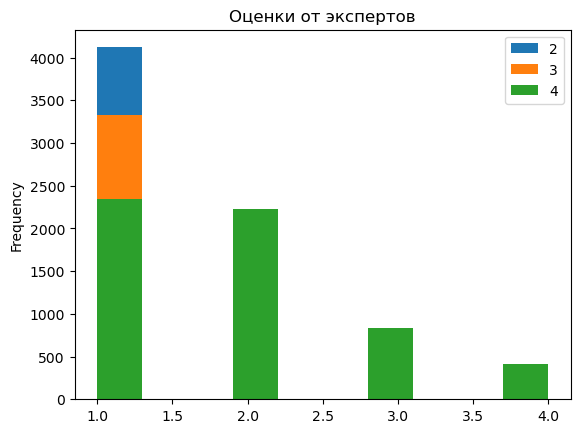

In [17]:
# оценим общее распределение оценок от 3 экспертов
df_expert.plot(kind='hist')
plt.title('Оценки от экспертов')

In [18]:
def score_agg(obs):
    """
    Агрегация оценок экспертов методом голосования большинством.
    """
    counts = Counter(obs)    
    if len(counts) == len(obs):
        return None
    else:
        majority_score = counts.most_common(1)[0][0]
    # нормализация оценок 
    normalized_score = (majority_score - 1) / 3
    return normalized_score

In [19]:
# применим функцию агрегации оценок
df_expert[5] = df_expert.apply(score_agg, axis=1)
# оценим долю наблюдений, где эксперты разошлись во мнениях
len(df_expert[df_expert[5].isna()])/len(df_expert)

0.02164204740638956

Text(0.5, 1.0, 'Краудсорсные оценки')

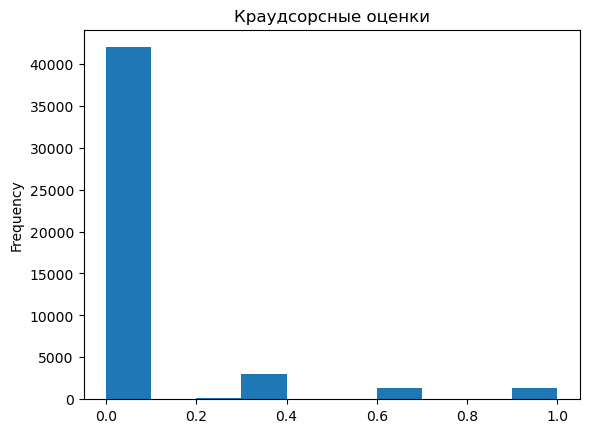

In [20]:
# оценим распределение доли оценок людей, подтвердивших, что описание соответствует изображению
df_crowd[2].plot(kind='hist')
plt.title('Краудсорсные оценки')

В основном люди на краудсорсинговых платформах отвечали, что изображения не соответствуют описанию
Мы видим, что у экспертов была более сложная шкала оценок, чем ответы "соответствует описанию"/"не соответствует", плюс у экспертов больше положительных ответов, чем у краудсорса. Поэтому больше доверия результатам экспертов - используем в работе их оценки, если они доступны для конкретного наблюдения.

In [21]:
#  объединим оценки так, чтобы отзывы экспертов имели больших приоритет
df_scores = pd.merge(df_expert[[0,1,5]], df_crowd[[0,1,2]], on=[0, 1], how='left')
df_scores['score'] = np.where(df_scores[5].isna(), df_scores[2], df_scores[5])

In [22]:
df_scores

0                            1         5  \
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2  0.000000   
1     1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2  0.000000   
2     1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2  0.000000   
3     1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2  0.333333   
4     1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2  0.000000   
...                         ...                          ...       ...   
5817   997722733_0cb5439472.jpg  2981702521_2459f2c1c4.jpg#2  0.000000   
5818   997722733_0cb5439472.jpg  2985679744_75a7102aab.jpg#2  0.000000   
5819   997722733_0cb5439472.jpg  3150742439_b8a352e1e0.jpg#2  0.000000   
5820   997722733_0cb5439472.jpg  3375070563_3c290a7991.jpg#2  0.000000   
5821   997722733_0cb5439472.jpg   486917990_72bd4069af.jpg#2  0.666667   

             2     score  
0     0.000000  0.000000  
1     0.000000  0.000000  
2          NaN  0.000000  
3          NaN  0.333333  
4          NaN  0.000000  
...        ...       ...  
5817       NaN  0.000000  
5818  0.000000  0.000000  
5819  0.000000  0.000000  
5820       NaN  0.000000  
5821  0.333333  0.666667  

[5822 rows x 5 columns]

In [23]:
df_train

image                     query_id  \
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1     1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2     2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3     2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4     2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
...                         ...                          ...   
5817   757046028_ff5999f91b.jpg  2061144717_5b3a1864f0.jpg#2   
5818   799486353_f665d7b0f0.jpg  2196107384_361d73a170.jpg#2   
5819   909808296_23c427022d.jpg  2112921744_92bf706805.jpg#2   
5820   929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2   
5821   968081289_cdba83ce2e.jpg  2292406847_f366350600.jpg#2   

                                             query_text  
0     A young child is wearing blue goggles and sitt...  
1     A young child is wearing blue goggles and sitt...  
2     A young child is wearing blue goggles and sitt...  
3     A young child is wearing blue goggles and sitt...  
4     A young child is wearing blue goggles and sitt...  
...                                                 ...  
5817         A man in an ampitheater talking to a boy .  
5818          a old man walks down the uncrowded road .  
5819       A dog stands on the side of a grassy cliff .  
5820                       A blurry photo of two dogs .  
5821                        A man rows his boat below .  

[5822 rows x 3 columns]

In [24]:
# уберем из обучающей выборки наблюдения, где нет никакой оценки
df_scores = df_scores.dropna(subset=['score'])
df_train = df_train.iloc[df_scores.index]
df_train = df_train.merge(df_scores, right_on=[0,1], left_on=['image', 'query_id'])
df_train.drop(columns=[0,1,5,2], inplace=True)

df_train.shape

(5712, 4)

После удаления данных без оценок со стороны экспертов и краудсорсинговой плтаформы количество наблюдений в тренировочной выборке уменьшилось с 5822 до 5767.

## Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [25]:
# создадим словарь для слов, связанных с детьми и подростками:
kid_words = [
    'girl', 'girls', 'boy', 'boys', 'teen', 'teens', 'child', 'children', \
    'baby', 'babies', 'teen', 'teens', 'teenage', 'teenager', 'infant', \
    'infants', 'newborn', 'newborns', 'toddler', 'toddlers', 'kid', 'kids']

In [26]:
# лемматизация

def get_wordnet_pos(word):
    """
    Получение POS тега для лемматизатора
    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    return text.lower()
    
# Функция для лемматизации текста
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

In [27]:
# применение предобработки и лемматизации к колонке query_text
df_train['lem_query_text'] = df_train['query_text'].apply(preprocess_text).apply(lemmatize)

# фильтрация строк, содержащих слова из списка stopwords
df_train_filtered = df_train[~df_train['query_text'].str.split().apply(lambda x: any(word in kid_words for word in x))]


In [28]:
df_train_filtered

image                     query_id  \
21    1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
22    3187395715_f2940c2b72.jpg  3181701312_70a379ab6e.jpg#2   
23     463978865_c87c6ca84c.jpg  3181701312_70a379ab6e.jpg#2   
24     488590040_35a3e96c89.jpg  3181701312_70a379ab6e.jpg#2   
25     534875358_6ea30d3091.jpg  3181701312_70a379ab6e.jpg#2   
...                         ...                          ...   
5706   799486353_f665d7b0f0.jpg  2170222061_e8bce4a32d.jpg#2   
5708   799486353_f665d7b0f0.jpg  2196107384_361d73a170.jpg#2   
5709   909808296_23c427022d.jpg  2112921744_92bf706805.jpg#2   
5710   929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2   
5711   968081289_cdba83ce2e.jpg  2292406847_f366350600.jpg#2   

                                             query_text     score  \
21      A man sleeps under a blanket on a city street .  0.000000   
22      A man sleeps under a blanket on a city street .  0.333333   
23      A man sleeps under a blanket on a city street .  0.333333   
24      A man sleeps under a blanket on a city street .  0.333333   
25      A man sleeps under a blanket on a city street .  0.000000   
...                                                 ...       ...   
5706  A small animal leaps behind a larger animal , ...  0.000000   
5708          a old man walks down the uncrowded road .  0.000000   
5709       A dog stands on the side of a grassy cliff .  0.333333   
5710                       A blurry photo of two dogs .  0.666667   
5711                        A man rows his boat below .  0.000000   

                                         lem_query_text  
21         a man sleep under a blanket on a city street  
22         a man sleep under a blanket on a city street  
23         a man sleep under a blanket on a city street  
24         a man sleep under a blanket on a city street  
25         a man sleep under a blanket on a city street  
...                                                 ...  
5706  a small animal leap behind a larger animal the...  
5708             a old man walk down the uncrowded road  
5709          a dog stand on the side of a grassy cliff  
5710                          a blurry photo of two dog  
5711                           a man row his boat below  

[4256 rows x 5 columns]

In [74]:
# применение предобработки и лемматизации к колонке query_text
df_test_query['lem_query_text'] = df_test_query['query_text'].apply(preprocess_text).apply(lemmatize)

# фильтрация строк, содержащих слова из списка stopwords
df_test_query_filtered = df_test_query[~df_test_query['query_text'].str.split().apply(lambda x: any(word in kid_words for word in x))]

In [34]:
# количество строк до и после фильтрации на слова, связанные с детьми
print(f"Количество строк до фильтрации: {len(df_train)}")
print(f"Количество строк после удаления дестких фото: {len(df_train_filtered)}")

Количество строк до фильтрации: 5712
Количество строк после удаления дестких фото: 4256


In [35]:
# количество строк до и после фильтрации на слова, связанные с детьми, на тестовых данных
print(f"Количество строк до фильтрации: {len(df_test_query)}")
print(f"Количество строк после удаления дестких фото: {len(df_test_query_filtered)}")

Количество строк до фильтрации: 500
Количество строк после удаления дестких фото: 344


## Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [38]:
# загрузка и подготовка модели ResNet-18
resnet = models.resnet18(pretrained=True)

for param in resnet.parameters():
    param.requires_grad_(False)

modules = list(resnet.children())[:-2]
resnet = nn.Sequential(*modules)

resnet.eval()

/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [39]:
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm,
])

In [40]:
# путь к папке с изображениями
image_folder_train = 'to_upload/train_images'
image_folder_test = 'to_upload/test_images'

In [41]:
# функция для получения эмбеддингов изображений
def get_image_embedding(image_path, model, preprocess):
    img = Image.open(image_path).convert('RGB')
    input_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        output_tensor = model(input_tensor).flatten()
    return output_tensor.numpy()

In [42]:
# получение эмбеддингов для обучающего набора изображений
train_image_paths = [os.path.join(path, 'train_images', img) for img in df_train_filtered['image']]
image_embeddings = np.array([get_image_embedding(img_path, resnet, preprocess) for img_path in train_image_paths])

In [43]:
print("Размер эмбеддингов изображений:", image_embeddings.shape)

Размер эмбеддингов изображений: (4256, 25088)


In [44]:
# получение эмбеддингов для тестовых изображений
test_image_paths = [os.path.join(path, 'test_images', img) for img in df_test_query['image']]
image_embeddings_test = np.array([get_image_embedding(img_path, resnet, preprocess) for img_path in test_image_paths])

In [45]:
print("Размер эмбеддингов изображений в тестовой выборке:", image_embeddings_test.shape)

Размер эмбеддингов изображений в тестовой выборке: (500, 25088)


## Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [46]:
stopwords = set(nltk_stopwords.words('english'))

In [47]:
# создание TF-IDF векторизатора
count_tf_idf = TfidfVectorizer(stop_words=list(stopwords))

# применение TF-IDF к обучающим данным
tf_idf_train = count_tf_idf.fit_transform(df_train_filtered['lem_query_text'])

print("Размер матрицы для обучающих данных:", tf_idf_train.shape)

# применение TF-IDF к тестовым данным (предполагая, что df_test_query['query_text'] уже предобработан)
df_test_query_filtered['lem_query_text'] = df_test_query_filtered['query_text'].apply(preprocess_text).apply(lemmatize)
tf_idf_test = count_tf_idf.transform(df_test_query_filtered['lem_query_text'])

print("Размер матрицы для тестовых данных:", tf_idf_test.shape)

Размер матрицы для обучающих данных: (4256, 1058)
Размер матрицы для тестовых данных: (344, 1058)


/var/folders/7y/hf5t75vx0szg0qpm9hpq75480000gn/T/ipykernel_33648/1011567227.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_query_filtered['lem_query_text'] = df_test_query_filtered['query_text'].apply(preprocess_text).apply(lemmatize)


## Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [49]:
# объединим векторные представления изображений и текста
features = np.concatenate((image_embeddings, tf_idf_train.toarray()), axis=1)

# целевая переменная
target = np.array(df_train_filtered['score'])

print("Размерность массива признаков:", features.shape)
print("Размерность целевой переменной:", target.shape)

Размерность массива признаков: (4256, 26146)
Размерность целевой переменной: (4256,)


## Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [51]:
# объединим эмбеддинги изображений и текстов
features = np.hstack((image_embeddings, tf_idf_train.toarray()))
target = df_train_filtered['score'].values
target = target.astype(int)
groups = df_train_filtered['image'].values

# проверим размеры массивов
print("Размерность признаков:", features.shape)
print("Размерность целевой переменной:", target.shape)
print("Размерность групп:", len(groups))

# используем GroupShuffleSplit для разделения данных
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=42)
train_indices, test_indices = next(gss.split(X=features, y=target, groups=groups))

# разделим данные на обучающую и тестовую выборку
features_train, features_test = features[train_indices], features[test_indices]
target_train, target_test = target[train_indices], target[test_indices]

print("Размерности обучающей выборки (признаки, целевая переменная):", features_train.shape, target_train.shape)
print("Размерности тестовой выборки (признаки, целевая переменная):", features_test.shape, target_test.shape)

Размерность признаков: (4256, 26146)
Размерность целевой переменной: (4256,)
Размерность групп: 4256
Размерности обучающей выборки (признаки, целевая переменная): (2972, 26146) (2972,)
Размерности тестовой выборки (признаки, целевая переменная): (1284, 26146) (1284,)


In [52]:
# стандартизация данных
scaler = StandardScaler()
scaler.fit(features_train)

features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

В качестве метрики качества модели выберем RMSE, т.к. для данной задачи важно оценить, насколько предсказания модели отклоняются от истинных значений. Также нужно отметить, что данная метрика является легко интерпретируемой, т.к. показатель находится в границах от 0 до 1 и отражает степень соответствия прогнозных показателей истинным.

In [53]:
# обучение модели
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(features_train, target_train)

# предсказание на тестовых данных
predictions = lr.predict(features_test)

# оценка качества модели
lr_score = mean_squared_error(target_test, predictions, squared=False)
print("RMSE:", lr_score)

RMSE: 0.31076230260882903


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [54]:
# создание сверточной нейросети
model_nn = Sequential()

optimizer = Adam(learning_rate=0.0001)
model_nn.add(Dense(units=features_train.shape[1], activation='relu'))
model_nn.add(Dense(units=1024, activation='relu'))
model_nn.add(Dense(units=1, activation='sigmoid'))
model_nn.compile(optimizer=optimizer, loss='mean_squared_error')

model_nn.compile(loss='mean_squared_error',
                optimizer=optimizer)

In [56]:
# обучим нейросеть
model_nn.fit(
    features_train,  
    target_train,    
    epochs=10,
    batch_size=32,   
    validation_data=(features_test, target_test),  
    validation_steps=math.ceil(features_train.shape[1] / 32), 
    verbose=2        
)

Epoch 1/10
93/93 - 167s - 2s/step - loss: 0.0633 - val_loss: 0.0561
Epoch 2/10


2024-07-09 21:03:00.968186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 - 243s - 3s/step - loss: 0.0633 - val_loss: 0.0561
Epoch 3/10


2024-07-09 21:07:03.701761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 - 215s - 2s/step - loss: 0.0633 - val_loss: 0.0561
Epoch 4/10


2024-07-09 21:10:38.362840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 - 188s - 2s/step - loss: 0.0633 - val_loss: 0.0561
Epoch 5/10


2024-07-09 21:13:45.893906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 - 180s - 2s/step - loss: 0.0633 - val_loss: 0.0561
Epoch 6/10


2024-07-09 21:16:46.350583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 - 265s - 3s/step - loss: 0.0633 - val_loss: 0.0561
Epoch 7/10


2024-07-09 21:21:11.271848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 - 267s - 3s/step - loss: 0.0633 - val_loss: 0.0561
Epoch 8/10


2024-07-09 21:25:38.442044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 - 264s - 3s/step - loss: 0.0633 - val_loss: 0.0561
Epoch 9/10


2024-07-09 21:30:02.883296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 - 245s - 3s/step - loss: 0.0633 - val_loss: 0.0561
Epoch 10/10


2024-07-09 21:34:08.228040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 - 267s - 3s/step - loss: 0.0633 - val_loss: 0.0561


2024-07-09 21:38:34.821216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [57]:
# предсказания модели
predictions = model_nn.predict(features_test)
nn_score = mean_squared_error(target_test, predictions, squared=False)
print("RMSE:", nn_score)

41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step
RMSE: 0.23680111138915752


В результате обучения модели логистической регрессии был получен RMSE=0.32
Также была обучена простая нейронная сеть, состоящая из нескольких полносвязных слоев. Нейронная сеть достигла среднеквадратичной ошибки на уровне 0.24.
Протестируем нейронную сеть на тестовой выборке.

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [62]:
test_image_paths = [os.path.join(path, 'test_images', img) for img in df_test_query['image']]
test_image_embeddings = np.array([get_image_embedding(img_path, resnet, preprocess) for img_path in test_image_paths])

In [65]:
# объединение текстовых и визуальных признаков
results = []
for i, query in random_queries.iterrows():
    query_embedding = tf_idf_test[random_queries_positions.get_loc(i)].toarray().reshape(1, -1)
    combined_features = np.hstack([test_image_embeddings, np.tile(query_embedding, (test_image_embeddings.shape[0], 1))])
    
    combined_features = combined_features.astype(np.float32)
    
    # применение модели для предсказаний
    scores = model_nn.predict(combined_features).flatten()
    
    most_similar_idx = np.argmax(scores)
    if most_similar_idx >= len(df_test_query):
        raise IndexError(f"Индекс {most_similar_idx} выходит за пределы диапазона изображений")
    
    most_similar_image = df_test_query.iloc[most_similar_idx]['image']
    
    # сохранение результатов

    results.append((query['query_text'], most_similar_image))
    

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step


Запрос: A snowboarder wearing a red jacket is going down a mountain .


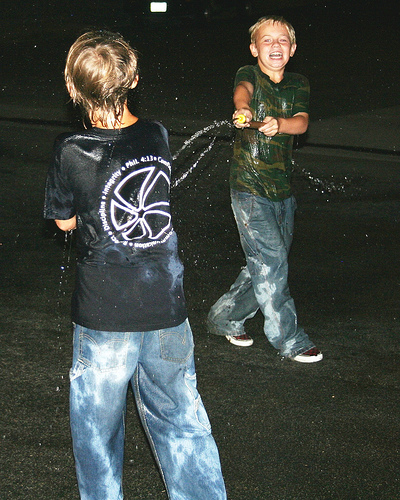

Запрос: Two Muslim woman wearing their head scarves and frowning faces .


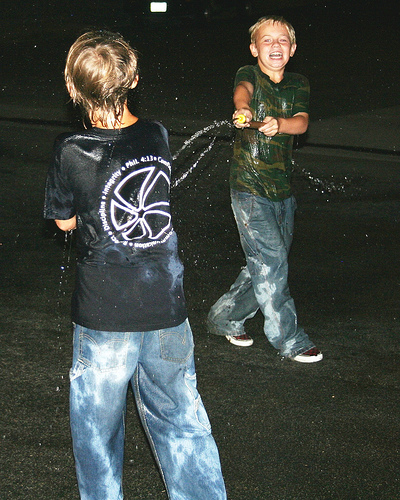

Запрос: Women wearing red and black are clapping .


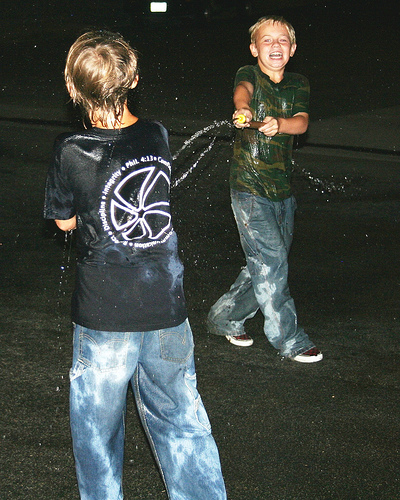

Запрос: A man playing tennis looks very happy .


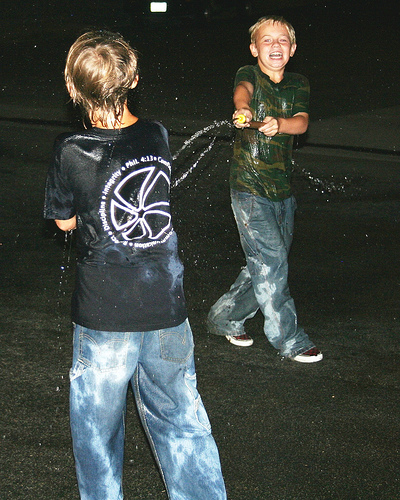

Запрос: A dog jumps to catch a red ball outside .


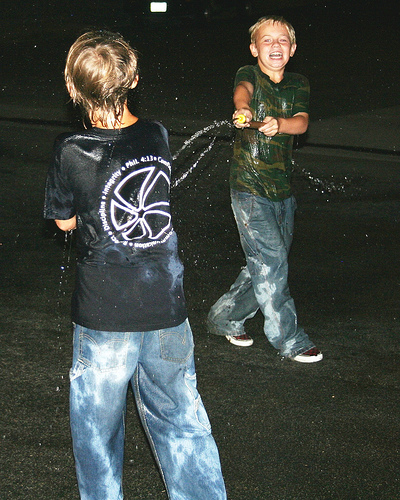

Запрос: Two women , one with a head bandanna , are standing next to each other while one holds a bottle .


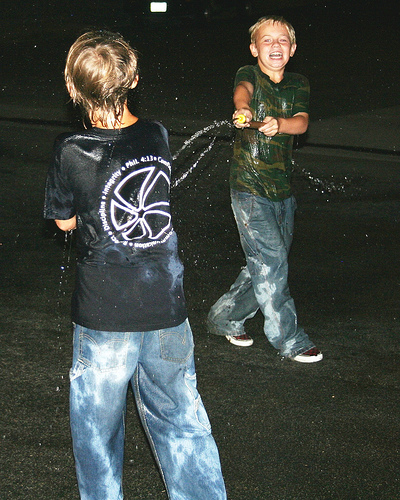

Запрос: a small shaggy dog plays with a red ball on the grass .


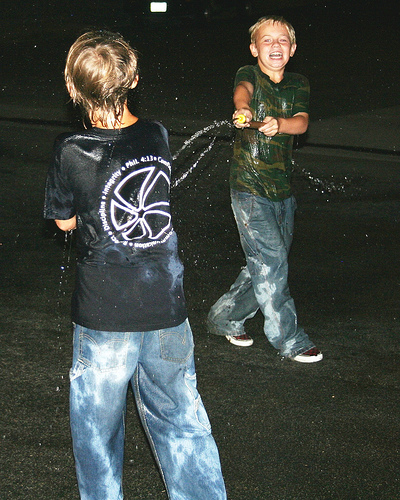

Запрос: A man on a red bicycle rides past several pedestrians .


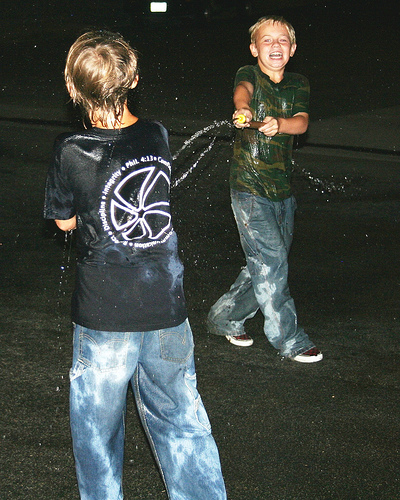

Запрос: Two people are in a tent near a brick wall .


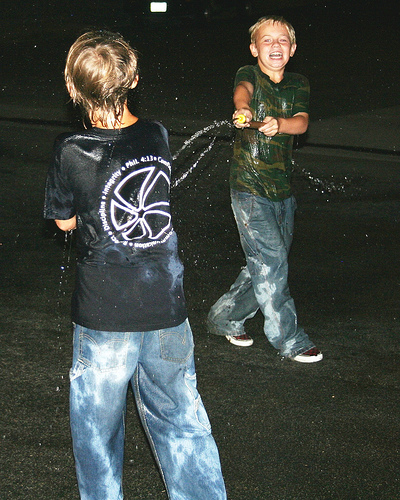

Запрос: The man is performing a trick with an orange bicycle .


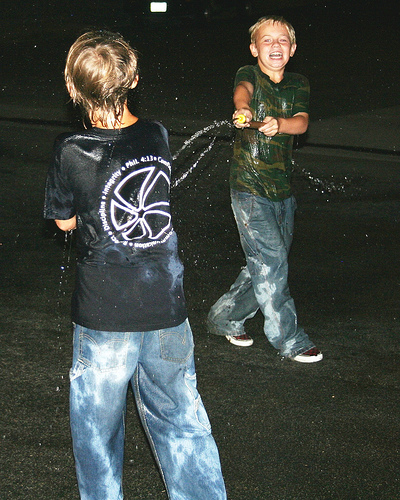

In [66]:
# вывод результатов
for query_text, image in results:
    print(f"Запрос: {query_text}")
    display(Image.open(os.path.join(path, 'test_images', image)))

Тестирование показало, что модель не работает: 10 рандомно взятых запросов  не соответствуют изображениям. Более того, выводятся изображения детей.

## Выводы

- Jupyter Notebook открыт
- Весь код выполняется без ошибок
- Ячейки с кодом расположены в порядке исполнения
- Исследовательский анализ данных выполнен
- Проверены экспертные оценки и краудсорсинговые оценки
- Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- Изображения векторизованы
- Текстовые запросы векторизованы
- Данные корректно разбиты на тренировочную и тестовую выборки
- Предложена метрика качества работы модели
- Предложена модель схожести изображений и текстового запроса
- Модель обучена
- По итогам обучения модели сделаны выводы
- Проведено тестирование работы модели
- По итогам тестирования визуально сравнили качество поиска